In [1]:
import math
import torch
import torch.distributions
from torch.distributions.binomial import Binomial
import matplotlib.pyplot as plt

### Binomial Distribution

Consider a dataset of photos that contains 20% of celebrity faces. Let us design an experiment where we select 3 photos from the dataset. The probability of success (picking up a celebrity photo) in a single trial is 0.2 `(p=0.2)`. Probability of failure (not picking up a celebrity photo) is `1 - p = 0.8`.

Say, we do `n=3` trials. The binomial distribution gives us the probability of picking up `k = 0` or `k = 1` or `k = 2` or `k = 3` celebrity photos in the 3 trials.

Formally, Binomial distribution is the probability distribution of `k` successes in `n` trials, where the probability of success in any given trial is known to be `(p)`.

This is given by the formula 
                          $$ P(X=k) = {n \choose k} p^k (1-p)^{ n-k} $$
where $ {n \choose k} = \frac{n!}{k!(n-k)!}$ (this is the number of ways in which we can choose k slots from n possible slots).

For our experiment, `n=3` and `p=0.2`. Substituting different values of `k` from 0 to 3, we have the following probability distribution
<table>
    <tr>
        <td>P(X=0) <td>0.512
    <tr>
    <tr>
        <td>P(X=1)<td>0.384
    <tr>
    <tr>
        <td>P(X=2)<td>0.096
    <tr>
    <tr>
        <td>P(X=3)<td>0.008
    <tr>
<table>
    
The mean of the distribution is given by n x p = 3 * 0.2 = 0.6

This is demonstrated by the PyTorch code below

In [2]:
# Indicates the number of times the coin is flipped in one experiment
num_trials = 3 

# Probability of success
p = 0.2 

# Instantiate the binomial distribution
binomial_dist = Binomial(num_trials, probs=torch.Tensor([p]))

In [3]:
# Instantiate single point test dataset
X = torch.tensor([1], dtype=torch.float)

def nCk(n, k):
    f = math.factorial
    return f(n) * 1. / (f(k) * f(n-k))

# Function to evaluate log prob using math formula
def raw_eval(X, n, p):
    result = nCk(n, X) * (p ** X) * (1 - p) ** (n - X)
    return torch.log(result)

# Evaluate log-prob using PyTorch distributions function call
log_prob = binomial_dist.log_prob(X)
print("Log Prob: {:.3f}".format(log_prob[0]))

# Evaluate log-prob using formula
raw_eval_log_prob = raw_eval(X, num_trials, p)
print("Raw eval Log Prob: {:.3f}".format(raw_eval_log_prob[0]))

assert torch.isclose(log_prob, raw_eval_log_prob, atol=1e-4)

Log Prob: -0.957
Raw eval Log Prob: -0.957


In [4]:
# Number of experiment runs (each with 3 trials)
num_samples = 1000000 

# Draw samples. Each element of the samples array represent the number of successes in that experiment.
samples = binomial_dist.sample(torch.Size([num_samples]))

In [5]:
# The mean obtained from the samples. Denotes the average number of successes
sample_mean = samples.mean()
print("Sample mean: {}".format(sample_mean))

# The mean of the distribution from Pytorch
dist_mean = binomial_dist.mean
print("Dist Mean: {}".format(dist_mean))

# As expected, the two means approximately match and are equal to num_trials * p = 3 * .2 = 0.6
assert torch.isclose(sample_mean, dist_mean, atol=0.2)

# The variance obtained from the samples 
sample_var = binomial_dist.sample([num_samples]).var()
print("Sample variance: {}".format(sample_var))

# The variance of the distribution from Pytorch
dist_var = binomial_dist.variance
print("Dist Variance: {}".format(dist_var))

# As expected, the two variances approximately match.
assert torch.isclose(sample_var, dist_var, atol=0.2)

Sample mean: 0.6000099778175354
Dist Mean: tensor([0.6000])
Sample variance: 0.4804621934890747
Dist Variance: tensor([0.4800])


## Visualization

In [6]:
# Let us now plot the distribution of the observed data
dist = []
for i in range(num_trials + 1):
    fraction = float(torch.sum(samples == i)) / num_samples
    dist.append((i, fraction))
    print("{} success: {}%".format(i, round(fraction * 100, 1)))

0 success: 51.2%
1 success: 38.4%
2 success: 9.6%
3 success: 0.8%


In [7]:
def plot_binomial_dist(dist):
    fig, ax = plt.subplots(figsize=(8, 6))
    x, y = [[d[0] for d in dist], [d[1] for d in dist]]
    ax.plot(x, y, 'bo')
    ax.vlines(x, 0, y, colors='r', alpha=0.5)
    
    ax.set_ylim(0)
    ax.set_xlabel("Number of Successes", fontsize=12)
    ax.set_ylabel("P(X=k)", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

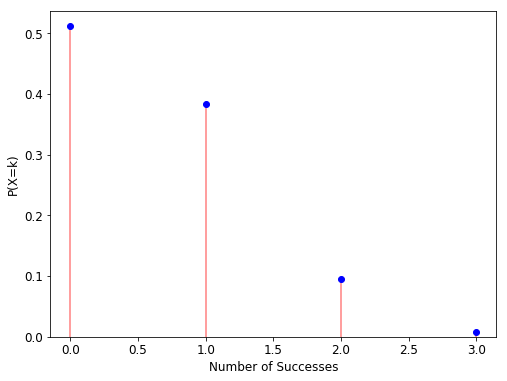

In [8]:
plot_binomial_dist(dist)

## Interactive Visualization

Here we allow the user to set different values for the $p$ and the number of trials for a Binomial distribution and visualise the resulting probability distribution function

Note: In order to run this section, please download the notebook. Interactive snippets do not work online. 

In [9]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

fig_1, ax_1 = plt.subplots(nrows=1, ncols=1)

@interact
def plot_binomial_distribution(p=(0.0, 1.0), num_trials=widgets.IntText(3)):
    def _reset_plot(ax):
        ax.clear()
        ax.set_ylim(0)
        ax.set_title("Binomial Distribution")
        ax.set_xlabel("Number of Successes", fontsize=12)
        ax.set_ylabel("P(X=k)", fontsize=12)
        
    num_samples = 1000
    binomial_dist = Binomial(num_trials, probs=torch.Tensor([p]))
    samples = binomial_dist.sample([num_samples])
    dist = []
    for i in range(num_trials + 1):
        fraction = float(torch.sum(samples == i)) / num_samples
        dist.append((i, fraction))
    x, y = [[d[0] for d in dist], [d[1] for d in dist]]
    _reset_plot(ax_1)
    ax_1.plot(x, y, 'bo')
    ax_1.vlines(x, 0, y, colors='r', alpha=0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

interactive(children=(FloatSlider(value=0.5, description='p', max=1.0), IntText(value=3, description='num_tria…